## Notebook description

In [1]:
import sys
sys.path.append("../")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from src.models import fine_tune, evaluate_fine_tune, \
    zero_shot_classifier, evaluate
from src.tools.startup import settings
from src.tools import utils as tools_utils
from src.visualization import plot_data

os.environ['SENTENCE_TRANSFORMERS_HOME'] = './.cache'

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-11-05 16:07:33 - Logger initialized


2023-11-05 16:07:33.257257: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 16:07:33.297832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 16:07:34.033725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Parameters

In [3]:
# Volumes
raw_folder = settings["volumes"]["raw"]
processed_folder = settings["volumes"]["processed"]
interim_folder = settings["volumes"]["interim"]

# Dataset
text_column = 'text_cleaned'
target_column = 'is_consultancy'

dataset_filepath = os.path.join(processed_folder, 'dataset.csv')

# Train test datasets
random_state = settings['random_state']
test_size = .2

train_filepath = os.path.join(interim_folder, 'train.csv')
test_filepath = os.path.join(interim_folder, 'test.csv')

# Parameter to fine-tune or not model
fine_tune_model = False

zero_shot = False

## Extract

In [4]:
df = pd.read_csv(dataset_filepath)

In [5]:
original_total_rows = df.shape[0]
print(f'Total rows {original_total_rows}')

df.shape

Total rows 791


(791, 31)

## Data preparation

#### Split data into train and test maintaining class ratios.

In [6]:
train_df, test_df = train_test_split(
    df, stratify=df[target_column], random_state=random_state)

In [7]:
print(f'Train size {train_df.shape}')
print(f'Test size {test_df.shape}')

Train size (593, 31)
Test size (198, 31)


In [8]:
test_df.shape

(198, 31)

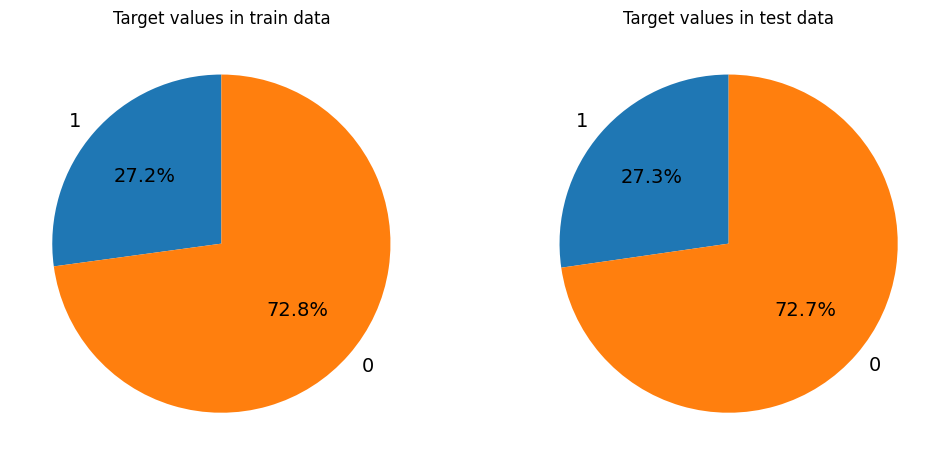

In [9]:
fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(1, 2, 1)
plot_data.create_pie_chart_with_grouped_threshold(
    train_df, target_column, threshold=.05, ax=ax1, 
    title='Target values in train data')

ax2 = fig.add_subplot(1, 2, 2)
plot_data.create_pie_chart_with_grouped_threshold(
    test_df, target_column, threshold=.02, ax=ax2, 
    title='Target values in test data')

#### Save train and test datasets

In [10]:
train_df.to_csv(train_filepath)
test_df.to_csv(test_filepath)

## Modeling

### Evaluate previous classifier

In [11]:
previous_model_df = test_df[[target_column, 'predicted_consultancy']].dropna()

baseline_metrics = evaluate.compute_classification_metrics(
    previous_model_df[target_column], previous_model_df['predicted_consultancy'])
baseline_classification_report = evaluate.compute_detailed_metrics(
    previous_model_df[target_column], previous_model_df['predicted_consultancy'])

print(f'Metrics\n{str(baseline_metrics)}\n')
print(f'Classification report\n{baseline_classification_report}')

Metrics
{'accuracy': 0.743455497382199, 'precision': 0.660663082437276, 'sensitivity': 0.6255602240896359, 'f1': 0.6353399571400741}

Classification report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       140
           1       0.53      0.37      0.44        51

    accuracy                           0.74       191
   macro avg       0.66      0.63      0.64       191
weighted avg       0.72      0.74      0.73       191



### Multilingual Bert model

#### Fine-tune 

In [12]:
if fine_tune_model:
    fine_tune.run(settings)

#### Evaluate

In [13]:
metrics, classification_report = evaluate_fine_tune.run(settings)

2023-11-05 16:07:35 - Device: cpu
2023-11-05 16:07:35 - Initializing execution 20231105_160735
2023-11-05 16:07:35 - Extracting pretrained model from /data/models/20231105_153420
2023-11-05 16:07:37 - Running tokenize...
2023-11-05 16:07:37 - Done.
2023-11-05 16:07:37 - Running convert_to_tensors...
2023-11-05 16:07:37 - Done.


100%|██████████| 25/25 [02:06<00:00,  5.07s/it]

2023-11-05 16:09:44 - Metrics
{'accuracy': 0.8888888888888888, 'precision': 0.8599537037037037, 'sensitivity': 0.8599537037037037, 'f1': 0.8599537037037037}
2023-11-05 16:09:44 - classification_report
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       144
           1       0.80      0.80      0.80        54

    accuracy                           0.89       198
   macro avg       0.86      0.86      0.86       198
weighted avg       0.89      0.89      0.89       198

2023-11-05 16:09:44 - Loss 0.30508982241153715
2023-11-05 16:09:44 - Accuracy: 0.8888888888888888
2023-11-05 16:09:44 - Precision: 0.8599537037037037
2023-11-05 16:09:44 - Sensitivity: 0.8599537037037037
2023-11-05 16:09:44 - F1: 0.8599537037037037


### Zero-shot Classification

In [17]:
if zero_shot:
    class_descriptions = [
        "non-consulting company", 
        "consulting company"
    ]
    
    zero_shot_classifier = zero_shot_classifier.ZeroShotClassifier(
        settings['zero_shot_classifier'])

    metrics, classification_report, predictions = zero_shot_classifier.evaluate(
        test_df['text_cleaned'], class_descriptions, test_df[target_column])
    
    print(f'Metrics\n{str(baseline_metrics)}\n')
    print(f'Classification report\n{baseline_classification_report}')

### Evaluation

In [18]:
baseline_metrics['model'] = 'baseline'
metrics['model'] = 'transformer'

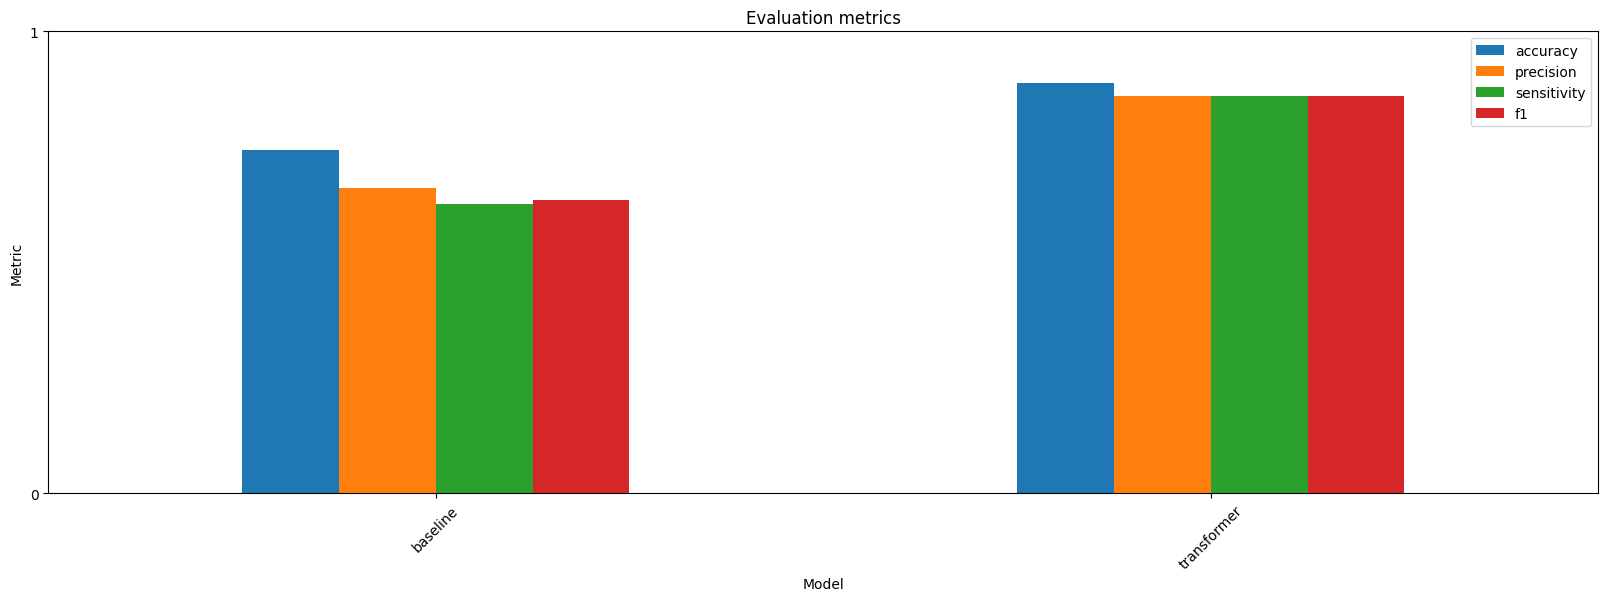

In [19]:
metrics_data = [
    baseline_metrics,
    metrics,
]
_ = pd.DataFrame(metrics_data) \
    .plot(kind='bar', x='model', yticks=(0, 1), figsize=(20, 6), 
          rot=45, ylabel='Metric', xlabel='Model', title='Evaluation metrics')